In [1]:
using DataFrames, CSV, UniversalDiffEq

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


# Kelp forest NODE model

This is a reletivly simple model for kelp forest dynamics that accounts for differnce between sites. It describes changes in the log abundance of juvile kelp (less than one meter) $u_{J,i}$ and adult kelp $u_{A,i}$ in each sites (index by $i$) as a function of their current log  abundances, the log abundnace of pycnopodia sea starts $X_{p,i}(t)$ and locaiton effects $X_i$. We assume no prior knowedge of these relationships and use a nerual network to learn the relevant funtional forms

$$
\frac{du_{J,i}}{dt} = NN_J(u_{J,i},u_{A,t}, X_{p,i}(t), X_i) \\
\frac{du_{A,i}}{dt} = NN_A(u_{J,i},u_{A,t}, X_{p,i}(t), X_i)
$$

I have chosen to model the effect of pycnopodial on kelp abundance rather than a sea urchin abundnace because the effects of these grazers on kelp often has more to do with urchin behavior than their numerical abundance. The behavioral respnce of these herbivors tend to be determined by the avaiabiltiy of food (i.e. the abundace of kelp) and predators like pycnopodia. 

The effects of location on the population dynamics are captured by a covarite $X_i$ that varies by site by not over time. In the simples case I ignore $X_i$ and assume the dynamcis are identical between sites. In the second case I assume there are unobserved site level factors that influence the dynamics which I model by passing an indicator varaible to the neural network and the final case assumes differnce in dynamics betwen location can be explained by the roughness of the sea floor at each location.  


In [210]:
dat = CSV.read("../data/processed_time_series.csv", DataFrame)[:,2:end]
rename!(dat, ["time","series","juv","adult"])
training = dat[dat.time .< 55,:]
testing = dat[dat.time .>= 55,:]
X = CSV.read("../data/processed_rugosity.csv", DataFrame)[:,[2,3,6,7]]
rename!(X, ["time","series", "pycnopodia",  "rugosity"])
dat[1:4,:]

4×4 DataFrame
 Row │ time   series  juv         adult     
     │ Int64  Int64   Float64     Float64   
─────┼──────────────────────────────────────
   1 │     1       1  -1.0498     -0.197155
   2 │     1       2  -0.0421156  -0.394327
   3 │     1       3   0.377395    0.211176
   4 │     1       4  -1.28535    -0.113676

In [211]:
X[1:4,:]

4×4 DataFrame
 Row │ time   series  pycnopodia  rugosity 
     │ Int64  Int64   Float64     Float64  
─────┼─────────────────────────────────────
   1 │     1       1   -0.532124  -0.87251
   2 │     1      23   -0.532124  -0.87251
   3 │     1      37   -0.532124  -0.87251
   4 │     1      47   -0.532124  -0.87251

# Model Fixed between sites

In [212]:
In this simplest case I assume the dynamcis are identical between sites. 

$$
\frac{du_{J,i}}{dt} = NN_J(u_{J,i},u_{A,t}, X_{p,i}(t)) \\
\frac{du_{A,i}}{dt} = NN_A(u_{J,i},u_{A,t}, X_{p,i}(t))
$$

UndefVarError: UndefVarError: `In` not defined

In [69]:
NN, NNparameters = SimpleNeuralNetwork(2+1,2, hidden = 5)

function derivs_1!(du,u,i,X,p,t)
    du .=  NN(vcat(u,X[1:1]), p.NN) # index 3 is pycnopodia 
end

init_parameters = (NN = NNparameters, )

model_1 = MultiCustomDerivatives(training,X,derivs_1!,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")
model_1.loss_function(model_1.parameters)


2.363551728278991

In [70]:
gradient_descent!(model_1, verbose = true, maxiter = 250, step_size = 0.05)
gradient_descent!(model_1, verbose = true, maxiter = 250, step_size = 0.025)

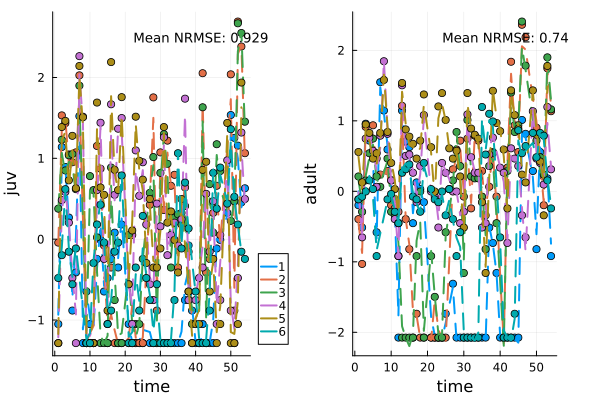

In [71]:
plot_state_estimates(model_1)

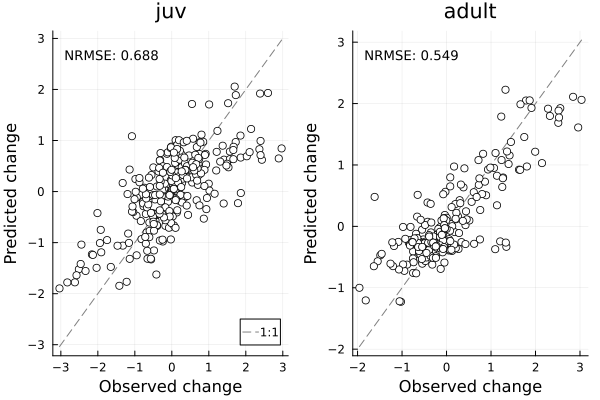

In [72]:
plot_predictions(model_1)

In [ ]:
# simulated the predicted dynamics 

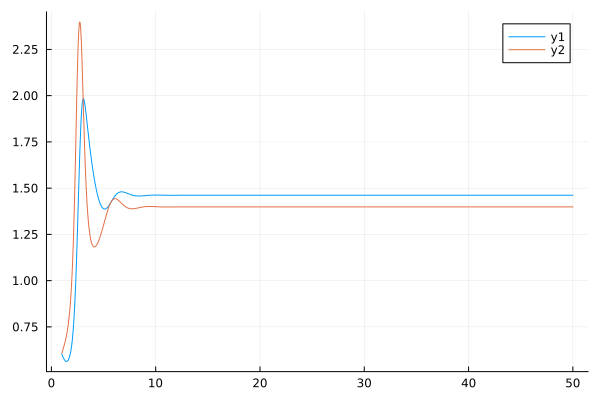

In [214]:
using Distributions, Plots

site = 3
with_noise = false
sigma = 2.0

rhs = u -> model_1.process_model.right_hand_side(u,site,[0.0,0.0,1.0],model_1.parameters.process_model, 0)
u = [-0.5,-0.5]
dt = 0.01
kelp = []
j_kelp = []

for i in 1:dt:50
    u = u .+ dt*rhs(u)
    if with_noise 
        u =  u .+ dt .* [sigma,0] .* (rand(Normal(0,1),2)) 
    end 
    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(1:dt:50,exp.(kelp))
Plots.plot!(1:dt:50,exp.(j_kelp))

# Model with site level indicators

I include site level indicator variables with a one-hot encoding which is a vector of zeros accept for one entry hat takes the value of one representing the site under consideration.  for example if there were four sites and we wanted to ake a prediciton for the third the one-hot encoding vector would be 

$$
X_3 = \{0,0,1,0\}
$$


In [101]:
NN, NNparameters = SimpleNeuralNetwork(2+7,2,hidden = 5)

function derivs_2!(du,u,i,X,p,t)
    index = round(Int,i)
    one_hot = zeros(6)
    one_hot[index] = 1
    inputs = vcat(vcat(u,X[1:1]),one_hot)
    du .=  NN(inputs ,p.NN)
end

init_parameters = (NN = NNparameters, )

model_2 = MultiCustomDerivatives(dat,X,derivs_2!,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")
nothing

In [102]:
gradient_descent!(model_2, verbose = true, maxiter = 250, step_size = 0.05)

In [103]:
gradient_descent!(model_2, verbose = true, maxiter = 250, step_size = 0.025)

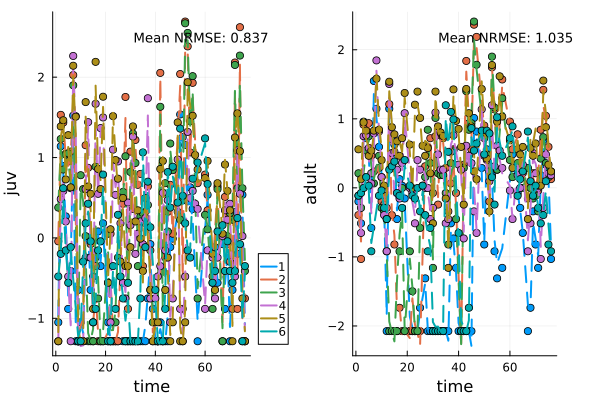

In [104]:
plot_state_estimates(model_2)

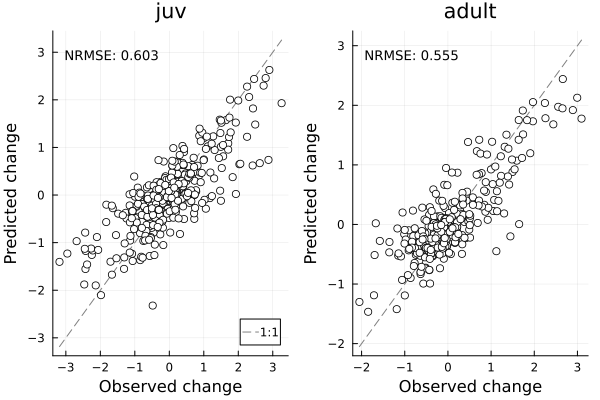

In [105]:
plot_predictions(model_2)

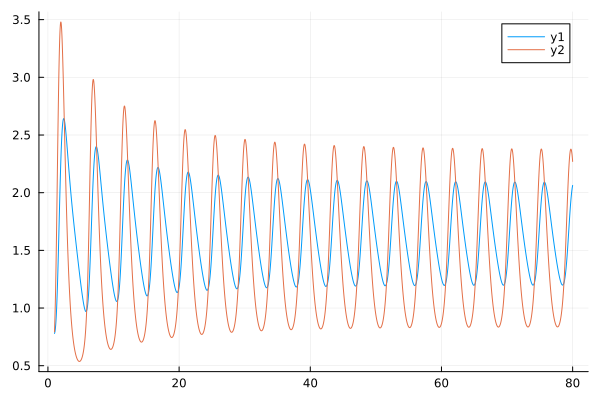

In [208]:
using Distributions
site = 4
with_noise = false
sigma = 0.5
pyc = 1.0

rhs = u -> model_2.process_model.right_hand_side(u,site,[0.0,0.0,pyc],model_2.parameters.process_model, 0)
u = [-0.25,-0.25]
dt = 0.01
kelp = []
j_kelp = []
ts = 1:dt:80
for i in ts
    u = u .+ dt*rhs(u)
    if with_noise 
        u =  u .+ dt .* sigma.* [1,0.1] .* rand(Normal(0,1),2)
    end 
    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(ts,exp.(kelp))
Plots.plot!(ts,exp.(j_kelp))

# Rugosity effects on dynamics 

for this last case I use site level measures of sea floor rugosity to explain differnce in the dynamcis betwen sites.  

In [132]:
NN, NNparameters = SimpleNeuralNetwork(2+2,2, hidden = 5)
function derivs_3!(du,u,i,X,p,t)
    inputs = vcat(u,X[1:2])
    du .=  NN(inputs,p.NN)
end

init_parameters = (NN = NNparameters, )

model_3 = MultiCustomDerivatives(training,X,derivs_3!,init_parameters;
                        proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                         time_column_name = "time", series_column_name = "series" )
nothing

In [133]:
gradient_descent!(model_3, verbose = true, maxiter = 250, step_size = 0.05)
gradient_descent!(model_3, verbose = true, maxiter = 250, step_size = 0.025)

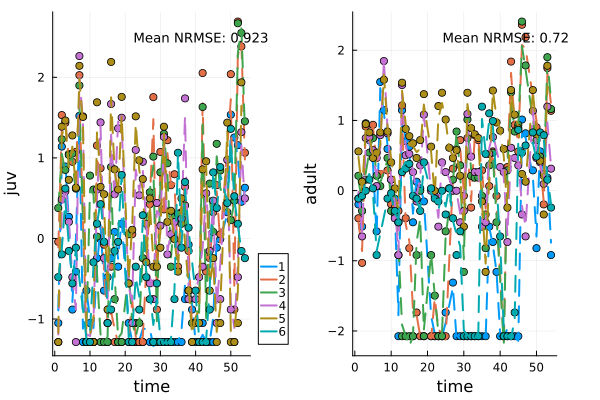

In [136]:
plot_state_estimates(model_3)

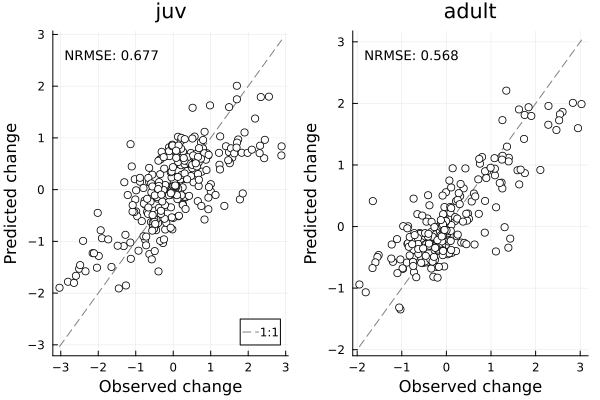

In [137]:
plot_predictions(model_3)

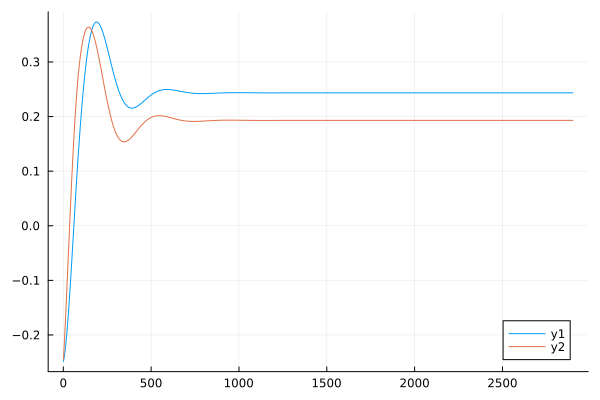

In [219]:
site = 1
pyc = 1.0
rug = 1.0
with_noise = false
sigma = 0.5
u = [-0.25,-0.25]

rhs = u -> model_3.process_model.right_hand_side(u,site,[0.0,0.0,pyc,rug],model_3.parameters.process_model, 0)

dt = 0.01
kelp = []
j_kelp = []
for i in 1:dt:30
    u = u .+ dt*rhs(u)
    if with_noise 
        u =  u .+ dt .*  [sigma,0.0] .* rand(Normal(0,1),2)
    end 
    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(kelp)
Plots.plot!(j_kelp)